## Prep data

In [1]:
import torch
import pandas as pd
from mihm.data.process import multi_cat_to_one_hot, binary_to_one_hot, standardize_cols, convert_categorical_to_ordinal
from mihm.data.dataset import MIHMDataset
import os
import numpy as np
from mihm.hyperparam.preprocess import preprocess

In [2]:
results_dir = "/home/namj/projects/heat_air_epi/results/June22_2024_traj_results"

In [3]:
data_path = '../Mar1_HeatResilience.dta'
# read model and rename cols
read_cols = ["zPCPhenoAge_acc", "zPCHorvath1_acc", 'zPCHorvath2_acc', 'zPCHannum_acc', 'zPCGrimAge_acc', 'zDunedinPACE_acc', 'PC_age',
            "m_HeatIndex_7d", "age2016", "female", "racethn", "eduy", "ihs_wealthf2016", "pmono", "PNK_pct", 
            "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",
            "smoke2016", "drink2016", "bmi2016", "tractdis", "urban", "mar_cat2", "psyche2016", "stroke2016", "hibpe2016",
            "diabe2016", "hearte2016", "ltactx2016", "mdactx2016", "vgactx2016", "dep2016", "adl2016", 
            "living2016", "division"]

rename_dict = {
    "zPCPhenoAge_acc": "Pheno Age Accel.", 
    "zPCHorvath1_acc": "Horvath1 Accel.",
    'zPCHorvath2_acc': "Horvath2 Accel.",
    'zPCHannum_acc': "Hannum Accel.", 
    'zPCGrimAge_acc': "GrimAge Accel.", 
    'zDunedinPACE_acc':"DunedinPACE Accel.",
    "PC_age": "PC age",
    "m_HeatIndex_7d": "mean heat index over 7d", 
    "age2016": "age", 
    "female": "female", 
    "racethn": "race/ethnicity", 
    "eduy": "education (in years)", 
    "ihs_wealthf2016": "household wealth (ihs)", 
    "smoke2016": "smoking status", 
    "drink2016": "drinking status", 
    "bmi2016": "bmi", 
    "tractdis": "tract disadvantage", 
    "urban": "urbanicity", 
    "mar_cat2": "marital status", 
    "psyche2016": "psychiatric conditions", 
    "stroke2016": "stroke", 
    "hibpe2016": "hypertension",
    "diabe2016": "diabetes", 
    "hearte2016": "heart disease", 
    "ltactx2016": "light activity", 
    "mdactx2016": "moderate activity", 
    "vgactx2016": "vigorous activity", 
    "dep2016": "depressive symptoms", 
    "adl2016": "adl limitations", 
    "living2016": "living alone", 
    "division": "census division"
}

interactor_col = "mean heat index over 7d"
outcome_col = "PC age"
controlled_cols = [
    'mean heat index over 7d',
    "pmono",
    "PNK_pct",
    "PBcell_pct",
    "PCD8_Plus_pct",
    "PCD4_Plus_pct",
    "PNCD8_Plus_pct",
]
interaction_predictors = ['female', 'education (in years)', 'household wealth (ihs)',
'smoking status', 'drinking status', 'bmi', 'tract disadvantage',
'marital status', 'psychiatric conditions', 'stroke', 'hypertension',
'diabetes', 'heart disease', 'light activity', 'moderate activity',
'vigorous activity', 'depressive symptoms', 'adl limitations',
'living alone', 'race/ethnicity_1. NHB',
'race/ethnicity_2. Hispanic', 'race/ethnicity_3. Others',
'urbanicity_2. suurban (code 2)', 'urbanicity_3. ex-urban',
'census division_Midwest', 'census division_South', 'census division_West']

# define variable types for preprocessing
categorical_cols = ['female', 'race/ethnicity', 'urbanicity', 'marital status', 'psychiatric conditions', 'stroke',
                    'hypertension', 'diabetes', 'heart disease', 'living alone', 'census division']
ordinal_cols = ['smoking status', 'drinking status', 'light activity', 'moderate activity', 'vigorous activity', 'adl limitations']
continuous_cols = ['education (in years)', 'household wealth (ihs)', 'age', 'bmi',
                   'tract disadvantage', 'depressive symptoms', 'adl limitations', 'mean heat index over 7d',
                    'pmono', "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct", "Pheno Age Accel."]

In [4]:
df_orig, heat_dataset = preprocess(
    data_path,
    read_cols,
    rename_dict,
    categorical_cols,
    ordinal_cols,
    continuous_cols,
    interactor_col,
    outcome_col,
    controlled_cols,
    interaction_predictors,
)

In [5]:
print("Mean and std of standardized predictors: ", heat_dataset.mean_std_dict)

Mean and std of standardized predictors:  {'education (in years)': (12.883308270676691, 3.1342179862584296), 'household wealth (ihs)': (5.4090805, 8.371072), 'age': (70.04451127819549, 9.23433744595856), 'bmi': (28.84815, 6.218937), 'tract disadvantage': (-0.012159855, 0.94902503), 'depressive symptoms': (1.3756391, 1.9412107), 'adl limitations': (1.7095765070919703e-17, 0.9999999999999999), 'mean heat index over 7d': (74.170525, 18.664015), 'pmono': (8.56896240601504, 2.425775207038868), 'PNK_pct': (0.09263381460765885, 0.05817143127709421), 'PBcell_pct': (0.06956864196926095, 0.05356930770984166), 'PCD8_Plus_pct': (0.2503239019150917, 0.12165371343251581), 'PCD4_Plus_pct': (0.6766124278740906, 0.13978046436234295), 'PNCD8_Plus_pct': (0.22016338784150424, 0.15927694059686853), 'Pheno Age Accel.': (-0.014999974, 0.99856097), 'smoking status': (0.676390977443609, 0.6654162517744427), 'drinking status': (0.4592481203007519, 0.6107067477432152), 'light activity': (2.3615037593984964, 1.10

### Split data into train test validation set 

In [6]:
from mihm.data.trainutils import train_test_val_split

In [7]:
if not os.path.exists(os.path.join(results_dir, "train_test_val_idxs.npz")):
    print("Creating train, test, val split")
    train_idx, test_idx, val_idx = train_test_val_split(len(heat_dataset))
    print("Train size: ", len(train_idx))
    print("Test size: ", len(test_idx))
    print("Val size: ", len(val_idx))
    # save train, test, val index
    np.savez("train_test_val_idxs.npz", train_idx=train_idx, test_idx=test_idx, val_idx=val_idx)
else:
    print("Loading train, test, val split")
    idxs = np.load(os.path.join(results_dir, "train_test_val_idxs.npz"))
    train_idx = idxs["train_idx"]
    test_idx = idxs["test_idx"]
    val_idx = idxs["val_idx"]

Loading train, test, val split


In [8]:
np.concatenate([test_idx, val_idx], axis=0)

array([ 271, 2670,  314, ...,  557, 3245,  470])

In [9]:
heat_dataset.outcome_original_name = "PC_age" # Hack to fix the outcome name for linear model fit
train_heat_dataset = heat_dataset.get_subset(train_idx)
test_heat_dataset = heat_dataset.get_subset(test_idx)
val_heat_dataset = heat_dataset.get_subset(np.concatenate([test_idx, val_idx], axis=0))

### Train

In [14]:
from mihm.hyperparam.train import train_mihm, test_mihm
import torch

In [15]:
del model

In [16]:
hidden_layer_sizes = [30, 10, 1]
vae=True
vae_loss = True
var_reg = 0.1
svd=True
k_dims=20
epochs=500
batch_size=800
lr=0.001
weight_decay=0.01
shuffle=True
eval=True
dropout=0.0
all_interaction_predictors = heat_dataset.to_tensor(device="cuda")["interaction_predictors"]
model_name = "PC_age"

In [17]:
model, traj_data = train_mihm(
    train_heat_dataset,
    val_heat_dataset,
    hidden_layer_sizes,
    vae,
    svd,
    k_dims,
    epochs,
    batch_size,
    lr,
    weight_decay,
    shuffle=shuffle,
    eval=eval,
    df_orig=df_orig,
    all_interaction_predictors=all_interaction_predictors,
    file_id=0,
    use_stata=True,
    return_trajectory=True,
    vae_loss=vae_loss,
    vae_lambda=var_reg,
    dropout=dropout,
)

Epoch 1/500 done!; Training Loss: 53274.69863128662; Testing Loss: 3.3533825874328613; Interaction Pval: 0.8933213253541664;
Epoch 2/500 done!; Training Loss: 7429795.446337382; Testing Loss: 3.3039751052856445; Interaction Pval: 0.9007217269864143;
Epoch 3/500 done!; Training Loss: 3191.6259075800576; Testing Loss: 3.2570912837982178; Interaction Pval: 0.9087276974093452;
Epoch 4/500 done!; Training Loss: 3991.308729171753; Testing Loss: 3.2118494510650635; Interaction Pval: 0.9126908292376432;
Epoch 5/500 done!; Training Loss: 382599.79662036896; Testing Loss: 3.1685495376586914; Interaction Pval: 0.9126684361549826;
Epoch 6/500 done!; Training Loss: 2438366.213873545; Testing Loss: 3.125210762023926; Interaction Pval: 0.9065024057307468;
Epoch 7/500 done!; Training Loss: 363.3764378229777; Testing Loss: 3.083066940307617; Interaction Pval: 0.9008382894836997;
Epoch 8/500 done!; Training Loss: 7916.527304331462; Testing Loss: 3.0418591499328613; Interaction Pval: 0.8956707579314607;


In [13]:
val_loss = test_mihm(model, test_heat_dataset.to_tensor(device="cuda"))
print("Validation loss: ", val_loss)

Validation loss:  1.5274989604949951


In [14]:
import pickle
with open(os.path.join(results_dir, 'traj_data_{}.pkl'.format(model_name)), 'wb') as f:
    pickle.dump(traj_data, f)
torch.save(model, os.path.join(results_dir, 'model_{}.pt'.format(model_name)))

## graph trajectory of the model

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [16]:
with open(os.path.join(results_dir, 'traj_data_{}.pkl'.format(model_name)), 'rb') as f:
    traj_data_loaded = pickle.load(f)

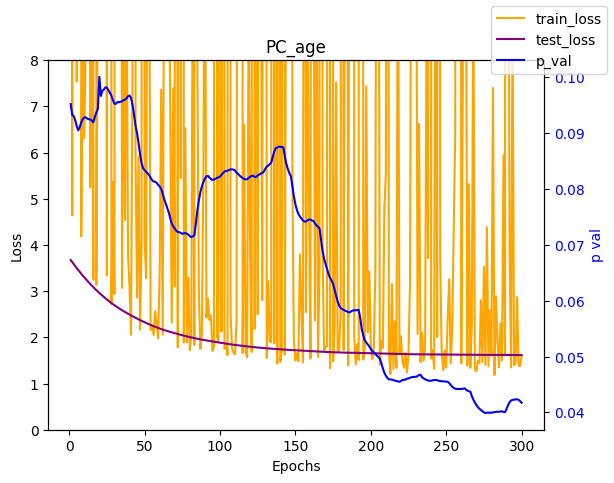

In [19]:
figpath = results_dir
fig, ax = plt.subplots()
x_data = np.arange(1, len(traj_data_loaded))
train_loss = [data["train_loss"] for data in traj_data_loaded[1:]]
test_loss = [data["test_loss"] for data in traj_data_loaded[1:]]
p_val = np.array([data["interaction_pval"] for data in traj_data_loaded[1:]])
p_val[p_val>1] = 0.1
ax.plot(x_data, train_loss, label="train loss", color="orange")
ax.plot(x_data, test_loss, label="test loss", color="purple")
ax.set_ylim(0, 8.0)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2 = ax.twinx()
ax2.plot(x_data, p_val, label="p val", color="blue")
ax2.set_ylabel("p val", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
fig.legend(["train_loss", "test_loss", "p_val"], loc="upper right")
ax.set_title("{}".format(model_name))
fig.savefig(os.path.join(figpath, "traj_{}.png".format(model_name)))


In [20]:
bias = model.interactor_bias.cpu().detach().numpy()*heat_dataset.mean_std_dict["mean heat index over 7d"][1] + heat_dataset.mean_std_dict["mean heat index over 7d"][0]
print("Interactor bias: {} ".format(bias))

Interactor bias: [[90.260544]] 


## Model prediction

In [16]:
from mihm.model.mihm import IndexPredictionModel
from mihm.model.modelutils import get_index_prediction_weights
import matplotlib.pyplot as plt
import torch

In [22]:
model_index = model.get_index_prediction_model()
model_index.cuda().eval()

IndexPredictionModel(
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (layers): ModuleList(
    (0): Linear(in_features=20, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [23]:
# get all interaction vars from the dataset
all_interaction_vars_tensor = heat_dataset.to_tensor(device="cuda")["interaction_predictors"]
mean_predicted_index = model_index(all_interaction_vars_tensor)
all_resilience_index = mean_predicted_index.detach().cpu().numpy()

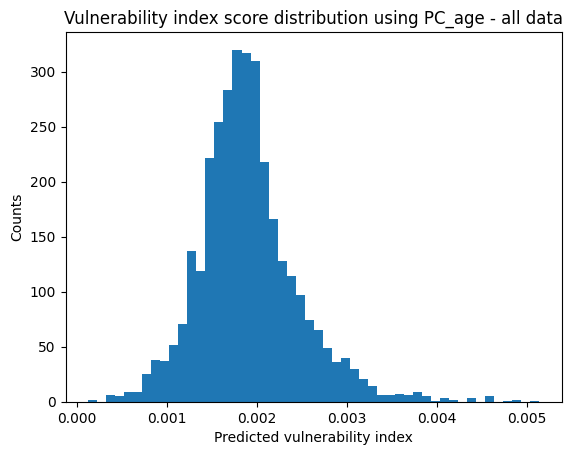

In [24]:
fig, ax = plt.subplots()
ax.hist(all_resilience_index, bins=50)
ax.set_xlabel("Predicted vulnerability index")
ax.set_ylabel("Counts")
ax.set_title("Vulnerability index score distribution using {} - all data".format(model_name))
fig.savefig(os.path.join(figpath, "vulnerability_index_dist_{}.png".format(model_name)))

In [25]:
# get all interaction vars from the dataset
all_interaction_vars_tensor = val_heat_dataset.to_tensor(device="cuda")["interaction_predictors"]
mean_predicted_index = model_index(all_interaction_vars_tensor)
all_resilience_index = mean_predicted_index.detach().cpu().numpy()

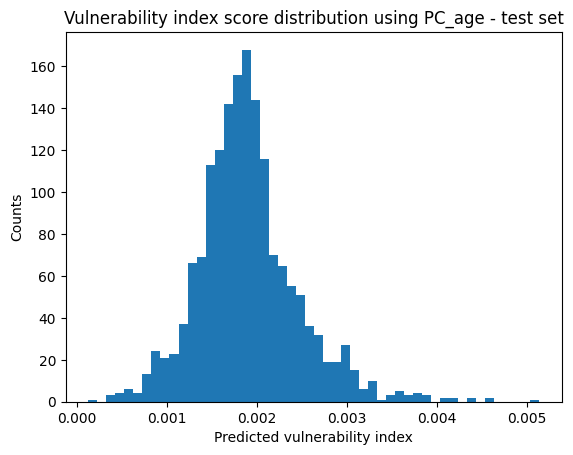

In [26]:
fig, ax = plt.subplots()
ax.hist(all_resilience_index, bins=50)
ax.set_xlabel("Predicted vulnerability index")
ax.set_ylabel("Counts")
ax.set_title("Vulnerability index score distribution using {} - test set".format(model_name))
fig.savefig(os.path.join(figpath, "vulnerability_index_dist_{}.png".format(model_name)))

In [27]:
predicted_index, predicted_index_std = model_index.get_index_mean_std(all_interaction_vars_tensor)

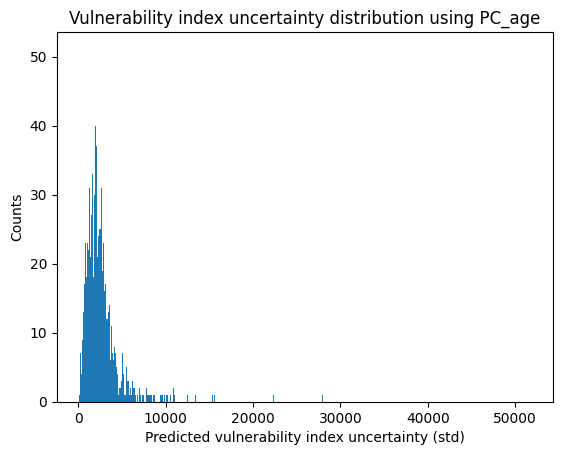

In [28]:
predicted_index_std = predicted_index_std.detach().cpu().numpy()
fig, ax = plt.subplots()
ax.hist(predicted_index_std, bins=1000)
ax.set_xlabel("Predicted vulnerability index uncertainty (std)")
ax.set_ylabel("Counts")
ax.set_title("Vulnerability index uncertainty distribution using {}".format(model_name))
fig.savefig(os.path.join(figpath, "vulnerability_index_std_dist_{}.png".format(model_name)))

In [30]:
np.mean(predicted_index_std)

2709.795

In [23]:
# get all interaction vars from the dataset
all_interaction_vars_tensor = heat_dataset.to_tensor(device="cuda")["interaction_predictors"]
mean_predicted_index = model_index(all_interaction_vars_tensor)
all_resilience_index = mean_predicted_index.detach().cpu().numpy()

NameError: name 'model_index' is not defined

In [36]:
df_orig = pd.read_stata(data_path)
df_orig["vul_index"] = all_resilience_index

In [17]:
save_name = "../data/HeatResilience_{}_June24.dta".format(model_name)
df_orig.to_stata(save_name, write_index=False)

## Confirm significance using linear regression on Stata

In [ ]:
data_path = "/home/namj/projects/heat_air_epi/data/HeatResilience_PC_age_June24.dta"


In [18]:
import stata_setup
stata_setup.config("/usr/local/stata17", "se")
from pystata import stata
import pandas as pd

In [19]:
%%stata
set scheme burd
graph set window fontface "Arial Narrow"


. set scheme burd

. graph set window fontface "Arial Narrow"
not available in non-GUI version

. 


In [20]:
load_cmd = 'use "{}", clear'.format(save_name)
stata.run(load_cmd)

In [21]:
# regress_cmd = "regress zPCPhenoAge_acc m_HeatIndex_7d age2016 i.female i.racethn eduy ihs_wealthf2016 pmono PNK_pct PBcell_pct PCD8_Plus_pct PCD4_Plus_pct PNCD8_Plus_pct smoke2016 i.drink2016 bmi2016 tractdis i.urban i.mar_cat2 psyche2016 stroke2016 hibpe2016 diabe2016 hearte2016 i.ltactx2016 i.mdactx2016 i.vgactx2016 dep2016 adl2016 i.living2016 i.division c.m_HeatIndex_7d#c.vul_index"
regress_cmd_2 = "regress {} m_HeatIndex_7d c.m_HeatIndex_7d#c.vul_index pmono PNK_pct PBcell_pct PCD8_Plus_pct PCD4_Plus_pct PNCD8_Plus_pct age2016 i.female i.racethn eduy ihs_wealthf2016 i.smoke2016 i.drink2016 bmi2016 tractdis i.urban i.mar_cat2 i.psyche2016 i.stroke2016 i.hibpe2016 i.diabe2016 i.hearte2016 dep2016 ltactx2016 mdactx2016 vgactx2016 i.living2016 i.division adl2016".format(train_heat_dataset.outcome_original_name)
stata.run(regress_cmd_2)
stata.run("vif")
out = stata.get_return()


      Source |       SS           df       MS      Number of obs   =     3,325
-------------+----------------------------------   F(38, 3286)     =     40.05
       Model |  2140.38432        38  56.3259031   Prob > F        =    0.0000
    Residual |  4621.92364     3,286   1.4065501   R-squared       =    0.3165
-------------+----------------------------------   Adj R-squared   =    0.3086
       Total |  6762.30796     3,324  2.03438867   Root MSE        =     1.186

------------------------------------------------------------------------------
      PC_age | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
m_HeatInd~7d |   .0057124   .0021489     2.66   0.008     .0014992    .0099256
             |
          c. |
m_HeatInd~7d#|
 c.vul_index |  -2.215629   .9184061    -2.41   0.016    -4.016335   -.4149224
             |
       pmono |  -.0211793   .0089861    -2.36   0.018    -.0387981   

In [22]:
import numpy as np

bottom10 = np.quantile(all_resilience_index, 0.1)
median = np.quantile(all_resilience_index, 0.5)
top10 = np.quantile(all_resilience_index, 0.9)

jump = abs(top10-bottom10)/2
margins_cmd = "margins, at(m_HeatIndex_7d =(30(10)100) vul_index=({:.2f}({:.2f}){:.2f}) ) atmeans".format(bottom10, 0.9*abs(top10-bottom10)/2, top10)
margins_plt_cmd = 'marginsplot, level(83.4) xtitle("Mean Heat Index Lagged 7days") ytitle("{}") title("") legend(order(1 "Least vulnerable (Bottom 10%)" 2 "Median" 3 "Most vulnerable (Top 10%)"))'.format(train_heat_dataset.outcome_original_name)
stata.run(margins_cmd, quietly=True)
stata.run(margins_plt_cmd, quietly=True)
stata.run('graph export {}, replace'.format(os.path.join(figpath, "ml_vul_PC_age_interaction.png")), quietly=True)  # Save the figure

NameError: name 'all_resilience_index' is not defined

In [43]:
corr_cmd = "pwcorr vul_index pred3_pe tractdis urban ltactx2016 living2016 m_HeatIndex_7d zPCPhenoAge_acc age2016 female eduy ihs_wealthf2016 dep2016 adl2016 stroke2016 hibpe2016 diabe2016 hearte2016"
stata.run(corr_cmd)


             | vul_in~x pred3_pe tractdis    urban lta~2016 liv~2016 m_Hea~7d
-------------+---------------------------------------------------------------
   vul_index |   1.0000 
    pred3_pe |   0.2222   1.0000 
    tractdis |   0.3858   0.5043   1.0000 
       urban |  -0.1266   0.1324  -0.0331   1.0000 
  ltactx2016 |  -0.1059  -0.0951  -0.0665  -0.0128   1.0000 
  living2016 |  -0.0854   0.0767   0.0617   0.0371  -0.0502   1.0000 
m_HeatInd~7d |   0.0306   0.1044   0.0461  -0.1074  -0.0567   0.0341   1.0000 
zPCPhenoAg~c |   0.1636   0.1002   0.0894   0.0324  -0.1764  -0.0076   0.0919 
     age2016 |  -0.1197  -0.0065  -0.1677   0.1188  -0.2333   0.1374   0.1037 
      female |   0.1097   0.0336   0.0275  -0.0156   0.1621   0.1354   0.0404 
        eduy |  -0.3820  -0.2480  -0.2470  -0.0513   0.1354   0.0383  -0.0916 
ihs_wea~2016 |  -0.0845  -0.2089  -0.2354   0.0197   0.0929   0.0023  -0.0334 
     dep2016 |   0.4691   0.1141   0.1596   0.0078  -0.1338   0.1106   0.0147 
     

In [45]:
regress_cmd_2 = "regress {} m_HeatIndex_7d c.m_HeatIndex_7d##c.pred3_pe pmono PNK_pct PBcell_pct PCD8_Plus_pct PCD4_Plus_pct PNCD8_Plus_pct age2016 i.female i.racethn eduy ihs_wealthf2016 i.smoke2016 i.drink2016 bmi2016 tractdis i.urban i.mar_cat2 i.psyche2016 i.stroke2016 i.hibpe2016 i.diabe2016 i.hearte2016 dep2016 ltactx2016 mdactx2016 vgactx2016 i.living2016 i.division adl2016".format(train_heat_dataset.outcome_original_name)
stata.run(regress_cmd_2)
stata.run("vif")

note: m_HeatIndex_7d omitted because of collinearity.

      Source |       SS           df       MS      Number of obs   =     3,325
-------------+----------------------------------   F(39, 3285)     =     38.93
       Model |  2137.66463        39  54.8119137   Prob > F        =    0.0000
    Residual |  4624.64332     3,285  1.40780619   R-squared       =    0.3161
-------------+----------------------------------   Adj R-squared   =    0.3080
       Total |  6762.30796     3,324  2.03438867   Root MSE        =    1.1865

------------------------------------------------------------------------------
      PC_age | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
m_HeatInd~7d |    .005371   .0029096     1.85   0.065    -.0003338    .0110759
m_HeatInd~7d |          0  (omitted)
    pred3_pe |   .0148344   .0082033     1.81   0.071    -.0012497    .0309185
             |
          c. |
m_HeatIn

m_HeatInd~7d |      6.96    0.143615
    pred3_pe |     18.37    0.054446
          c. |
m_HeatInd~7d#|
  c.pred3_pe |     25.21    0.039664
       pmono |      1.12    0.890029
     PNK_pct |      1.11    0.900418
  PBcell_pct |      1.13    0.884859
PCD8_Plus_~t |      8.42    0.118727
PCD4_Plus_~t |      8.79    0.113716
PNCD8_Plus~t |      1.70    0.587081
     age2016 |      1.77    0.565629
    1.female |      1.27    0.790106
     racethn |
          1  |      1.59    0.630063
          2  |      1.70    0.587917
          3  |      1.07    0.935605
        eduy |      1.44    0.693018
ihs_wea~2016 |      1.34    0.745023
   smoke2016 |
          1  |      1.19    0.839898
          2  |      1.26    0.791974
   drink2016 |
          1  |      1.17    0.854793
          2  |      1.13    0.885863
     bmi2016 |      1.27    0.789205
    tractdis |      1.66    0.601231
       urban |
          1  |      1.20    0.830792
          2  |      1.37    0.730225
  1.mar_cat2 |      1.

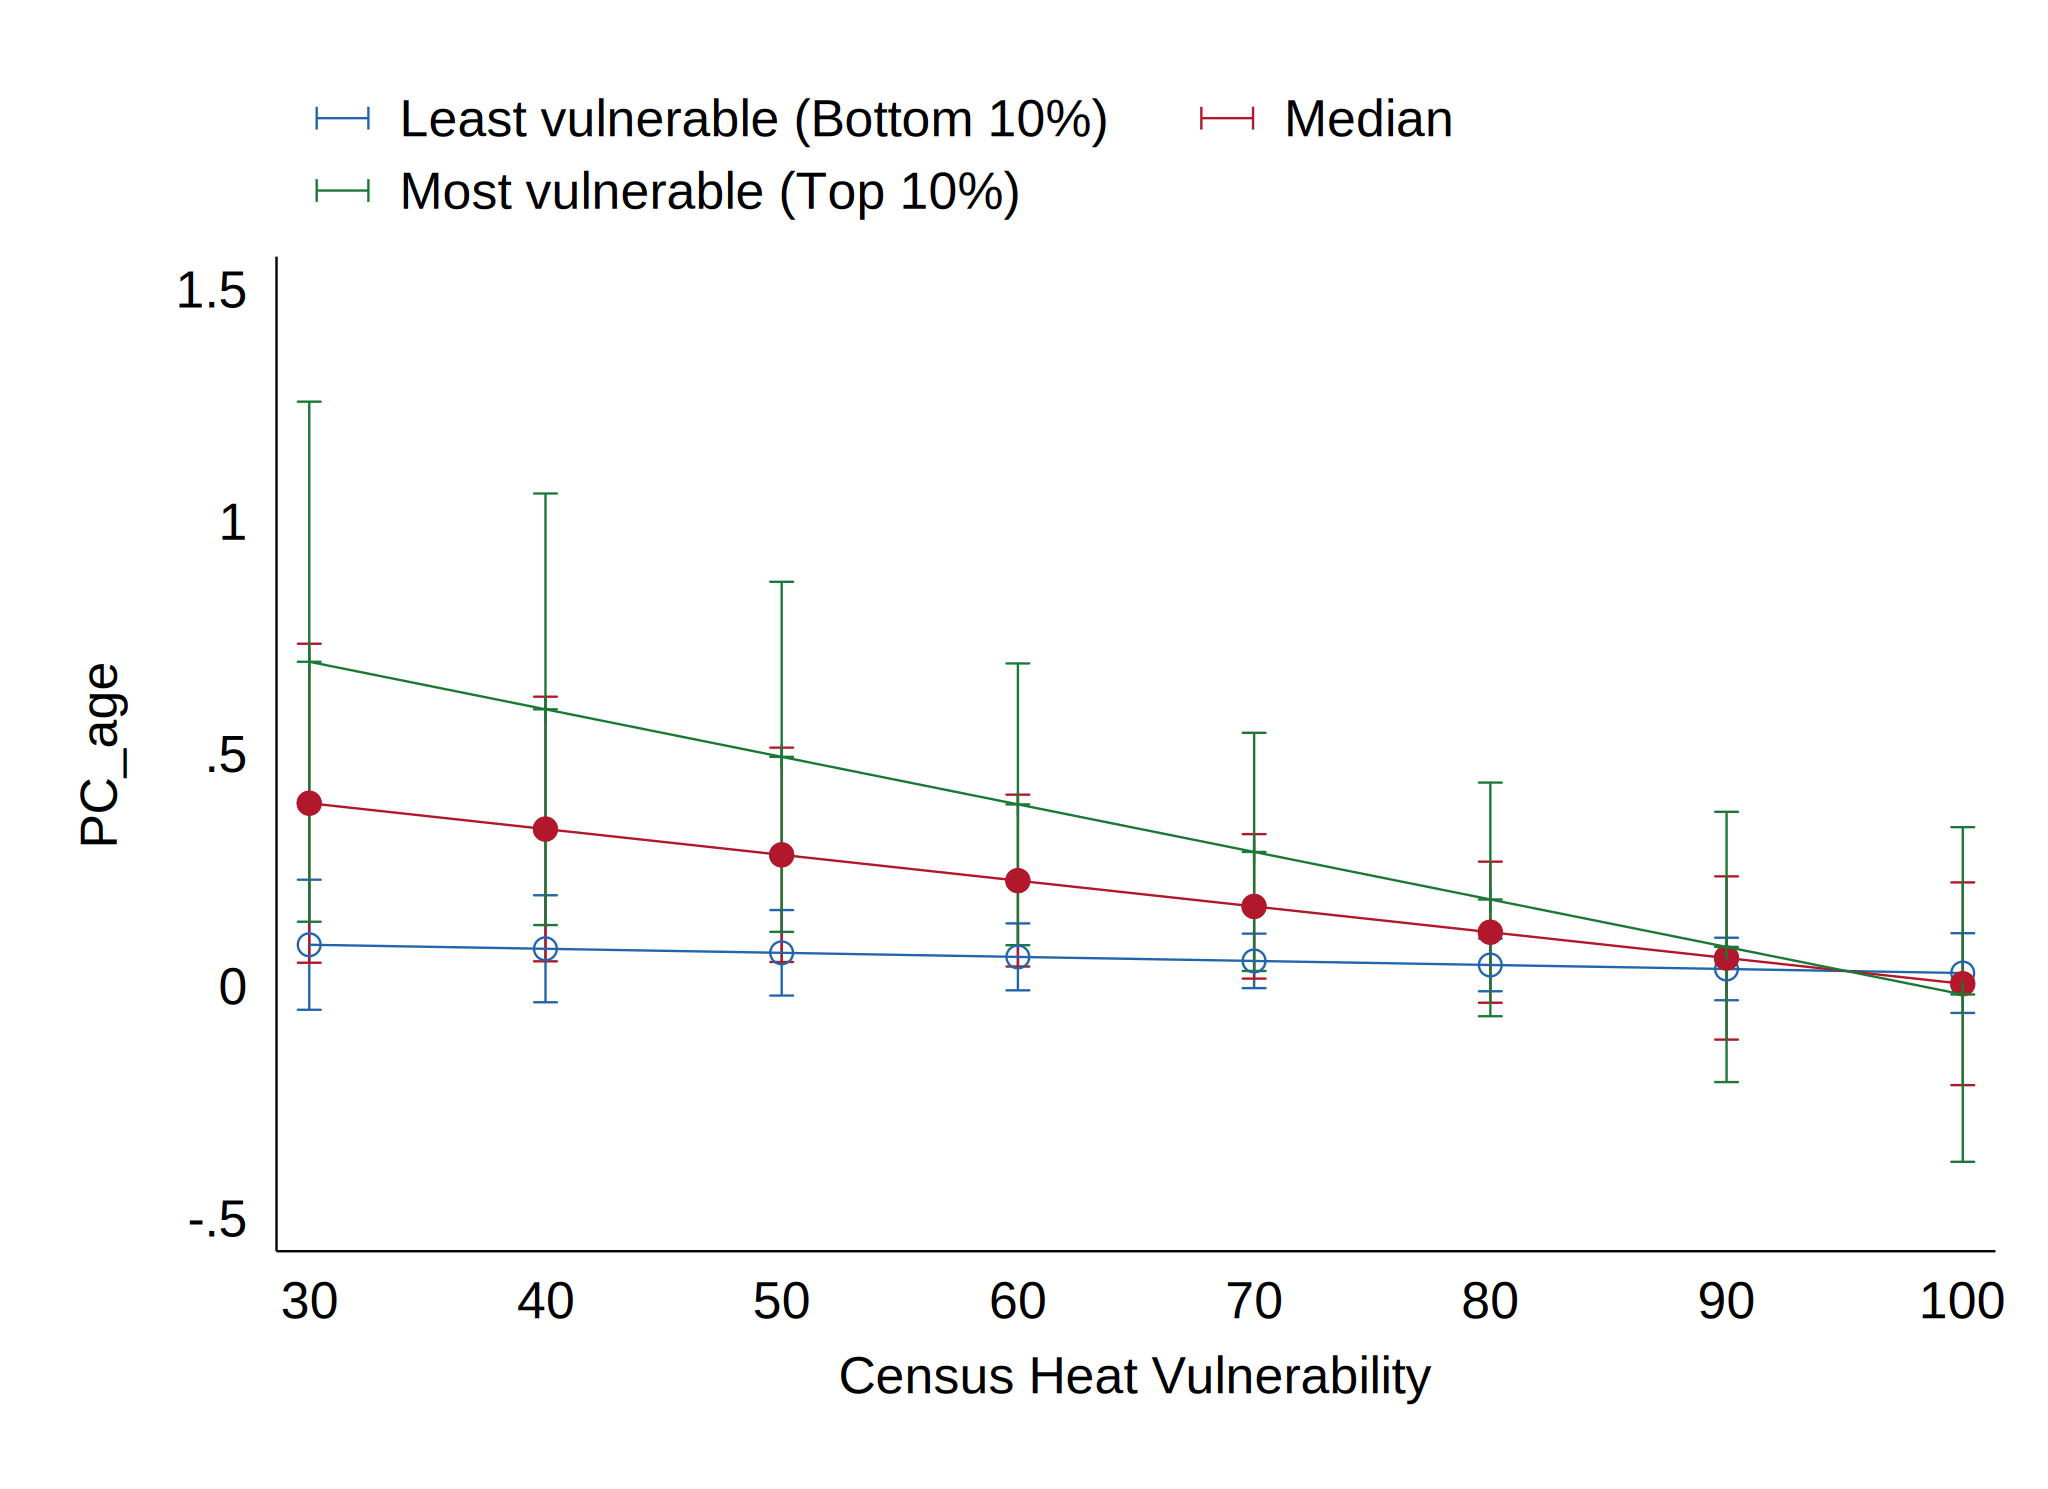

In [46]:
margins_cmd = "margins, at(m_HeatIndex_7d =(30(10)100) pred3_pe=({:.2f}({:.2f}){:.2f}) ) atmeans".format(40, 30, 100)
margins_plt_cmd = 'marginsplot, level(83.4) xtitle("Census Heat Vulnerability") ytitle("{}") title("") legend(order(1 "Least vulnerable (Bottom 10%)" 2 "Median" 3 "Most vulnerable (Top 10%)"))'.format(train_heat_dataset.outcome_original_name)
stata.run(margins_cmd, quietly=True)
stata.run(margins_plt_cmd, quietly=True)
stata.run('graph export {}, replace'.format(os.path.join(figpath, "census_vul_{}_interaction.png".format(train_heat_dataset.outcome_original_name))), quietly=True)  # Save the figure

## Model Analysis using Shapley values

In [47]:
import shap
import matplotlib.pyplot as plt
shap.initjs()

In [48]:
explainer = shap.DeepExplainer(model_index, all_interaction_vars_tensor)

In [49]:
shap_values = explainer.shap_values(all_interaction_vars_tensor[:1000], check_additivity=False)

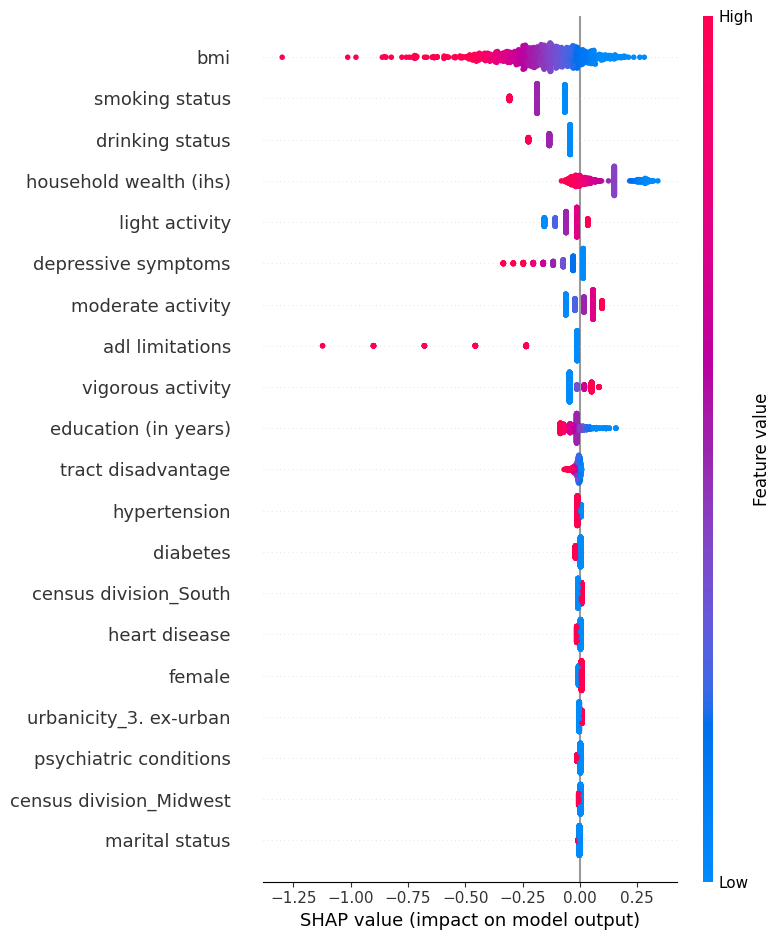

In [ ]:
shap.summary_plot(shap_values[:, :], all_interaction_vars_tensor[:1000, :].detach().cpu().numpy(), feature_names=interaction_predictors, show=False)
plt.savefig(os.path.join(figpath, "{}_shapley.png".format(model_name)), dpi=300, bbox_inches="tight")